# Copy instead of modifying to preserve attack parameters

In [87]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
RUNS = 5
TRIAL = 1

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion import AutoConjugateGradient as ACG

import pandas as pd
import numpy as np

import KBMproject.utilities as utils

from joblib import Parallel, delayed

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
agents = []
for _ in range (RUNS):
    agents.append(PPO.load(path=f"{AGENT_NAME}"))

In [5]:
envs = []
for _ in range (RUNS):
    envs.append(utils.make_discrete_env(schema=schema,  
                            action_bins=agents[0].action_space[0].n,
                            seed=42))

Unperturbed agent performance

In [7]:
import os
path = os.path.join(os.getcwd(), '..','observation_masks.csv') #get adversary from parent directory
path = os.path.normpath(path) #resolve '..'
observation_masks = pd.read_csv(path)

In [ ]:
%%time
init = 20
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
kwargs = dict(
    ART_atk=ACG,
    ART_atk_kwargs=ACG_parameters,
    eps_candidates=[0.01,0.03,0.05,0.07],
    time_steps=None,
    mask=observation_masks['mask_time'].to_numpy(),
    init_step_coeff=2,
)

results = Parallel(n_jobs=RUNS, verbose=10, prefer='threads')(delayed(
    utils.eval_untargeted_dynamic_distortion_attack)(agent, env, **kwargs) for agent, env in zip(agents, envs)) 


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 868.8min finished

Results is a list of tupples for each run, of the format(KPIs, observations, perturbed observations, epsilons)

In [126]:
for run in range(RUNS):
        np.savetxt(f'run {run} obs {TRIAL}.csv', results[run][1], delimiter=",")
        np.savetxt(f'run {run} adv_obs {TRIAL}.csv', results[run][2], delimiter=",")

In [88]:
kpis = [results[i][0] for i in range(len(results))]
df_kpis = pd.concat(kpis, axis='columns',keys=range(RUNS))

In [89]:
df_kpis[['mean', 'std', 'variance']] = df_kpis.agg(['mean','std', 'var'], axis='columns')

In [92]:
df_kpis.to_csv(f'{RUNS} run KPIs {TRIAL}.csv')

In [98]:
df_kpis

,0,1,2,3,4,mean,std,variance
cost_function,,,,,,,,
annual_peak_average,1.340799,1.198347,1.198347,1.336635,1.198347,1.254495,0.076898,5.913313e-03
carbon_emissions_total,0.905305,0.905949,0.903067,0.906009,0.904669,0.905000,0.001210,1.464550e-06
cost_total,0.821299,0.820694,0.819520,0.823444,0.820695,0.821130,0.001445,2.089429e-06
daily_one_minus_load_factor_average,0.340251,0.365851,0.352087,0.388326,0.382779,0.365859,0.020227,4.091320e-04
daily_peak_average,0.964378,0.981558,0.978818,0.975169,0.965866,0.973158,0.007696,5.922986e-05
electricity_consumption_total,0.913364,0.913713,0.911322,0.913760,0.912735,0.912979,0.001013,1.026025e-06
monthly_one_minus_load_factor_average,1.003274,0.996344,0.998209,1.002030,0.999535,0.999879,0.002809,7.888547e-06
ramping_average,1.289508,1.293732,1.277046,1.286056,1.275453,1.284359,0.007906,6.251002e-05
zero_net_energy,1.108946,1.108697,1.108445,1.108554,1.108754,1.108679,0.000192,3.693766e-08


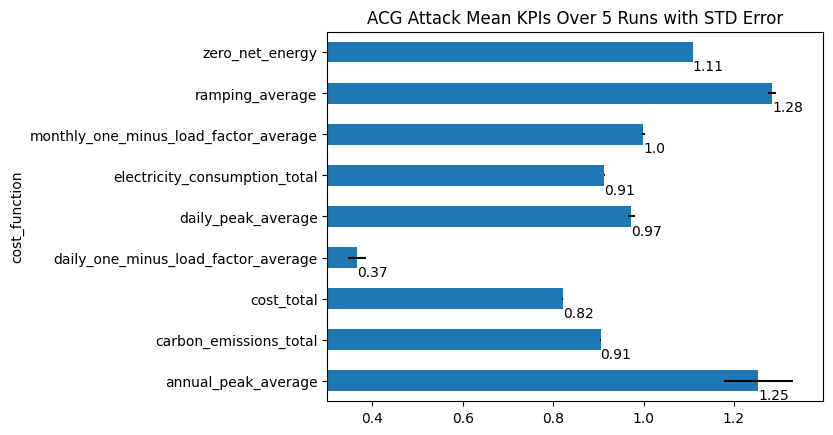

In [119]:
ax = df_kpis['mean'].plot.barh(xerr = df_kpis['std'], xlim=0.3, title='ACG Attack Mean KPIs Over 5 Runs with STD Error')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), 
            i.get_y()-0.2,
            str(round((i.get_width()), 2)), 
            fontsize=10, 
            #color='dimgrey'
            )

In [29]:
eps = [pd.Series(results[i][3]) for i in range(len(results))]
df_eps = pd.concat(eps, axis='columns',keys=range(RUNS))

In [34]:
df_eps.to_csv(f'{RUNS} run epsilons {TRIAL}.csv')

In [77]:
eps_value_counts = df_eps.apply(lambda col: col.value_counts(), axis='rows')

Calculate the ASRs (notna returns a series of 0 or 1 for True or False, to the mean is the proportion)

In [78]:
ASRs = df_eps.notna().mean()
ASRs.name = 'ASR'
eps_value_counts = eps_value_counts.append(ASRs)
eps_value_counts[['mean', 'std', 'variance']] = eps_value_counts.agg(['mean','std', 'var'], axis='columns')

In [82]:
eps_value_counts

,0,1,2,3,4,mean,std,variance
0.01,3900.00000,3919.000000,3919.000000,3928.000000,3921.000000,3917.400000,10.406729,1.083000e+02
0.03,3681.00000,3697.000000,3678.000000,3673.000000,3676.000000,3681.000000,9.407444,8.850000e+01
0.05,927.00000,900.000000,909.000000,908.000000,903.000000,909.400000,10.502381,1.103000e+02
0.07,203.00000,186.000000,202.000000,204.000000,206.000000,200.200000,8.074652,6.520000e+01
ASR,0.99452,0.993492,0.994177,0.994748,0.993949,0.994177,0.000491,2.411363e-07


<Axes: title={'center': 'Mean Epsilon Values of 5 runs'}, ylabel='mean'>

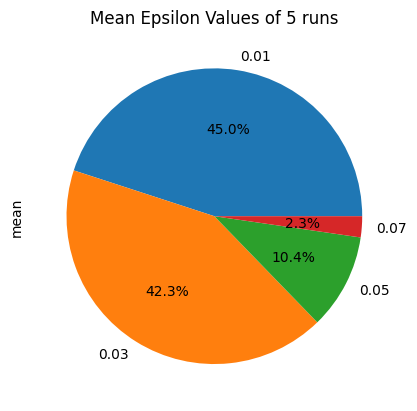

In [129]:
eps_value_counts['mean'].iloc[:-1].plot.pie(autopct='%1.1f%%', title=f'Mean proportions of different $\epsilon$ values over {RUNS} runs of the untargeted ACG attack using the dynamic distortion')